# Lab 4: GANs
Welcome to COMSM0159 Advanced Visual AI (AVAI)!

The goal of this labsheet is to provide an introduction to Generative Adversarial Networks (GANs) based on the week 4 lecture. By the end of this lab, you should be able to:
1. Understand the architecture of GANs and their two components: the generator and the discriminator.
2. Train a GAN on the MNIST dataset to generate handwritten digits.
3. Experiment with the challenge: denoising images using MNIST dataset

## What are GANs?

Generative Adversarial Networks (GANs) are a class of machine learning models where two networks, a generator and a discriminator, are trained simultaneously. The generator ("the artist") creates data that resembles real samples, while the discriminator ("the art critic") evaluates whether the data is real or fake. Two models are trained simultaneously by an adversarial process.

![Generative Adversarial Networks](./intro/gan.png)

During training, the generator improves its ability to create realistic images, while the discriminator becomes better at distinguishing real images from fakes. This adversarial process continues until the discriminator can no longer reliably tell the difference, meaning the generator's images are indistinguishable from real ones.

![Generative Adversarial Networks](./intro/gan2.png)

 In today's lab, we will use the MNIST dataset to explore this process. The generator starts by producing images from random noise. As training progresses, these images gradually transform into more recognizable representations of handwritten numbers, improving their resemblance with each iteration.

### Step 1 - Setup: Import necessary libraries and load MNIST dataset
You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

- Data Loading: In PyTorch, torchvision.datasets provides the MNIST dataset. 
- DataLoader: The DataLoader in PyTorch handles batching and shuffling the data, making it easier to work with large datasets.

In [178]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import time
from PIL import Image

# For GPU (CUDA) or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Or for ARM-based MacOS
# device = torch.device('mps')  # Only applicable if running on a Mac with M1/M2 chip and PyTorch with MPS support

# Load and preprocess the MNIST dataset; downloading if not already present.
train_dataset = datasets.MNIST(root="./data/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

### Step 2 -  Create the models: The Generator
In PyTorch, both the generator and discriminator models can be defined using the **nn.Sequential**.

- The generator starts with **nn.Linear()** layer to project the random noise (input) into a higher-dimensional space.
- **nn.Linear()** to further increase the dimensionality of the data, followed by reshaping it for convolutional layers.
- **nn.ConvTranspose2d()** layers are used to upsample the data until it reaches the target image size.
- Each layer is followed by:
  - **nn.BatchNorm2d()** or **nn.BatchNorm2d()** to normalize the outputs of the previous layer.
  - **nn.LeakyReLU()** activation to introduce non-linearity.
- The output layer uses **nn.Sigmoid()** activation to constrain the output to the range [0, 1].

In [179]:
class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32 * 32)
        self.br1 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(32 * 32, 128 * 7 * 7)
        self.br2 = nn.Sequential(
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU()
        )
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),  # Final upsampling to 28x28x1
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.br1(self.fc1(x))
        x = self.br2(self.fc2(x))
        # Reshape the tensor for the convolutional layers
        x = x.reshape(-1, 128, 7, 7)
        x = self.conv1(x)
        output = self.conv2(x)
        return output

Use the untrained generator to create an image.

torch.Size([1, 1, 28, 28])


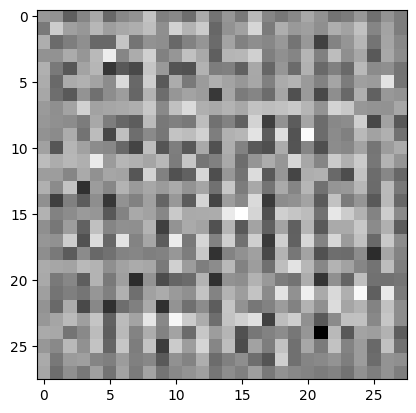

In [180]:
# Instantiate the generator
# You can try to adjust this value, e.g. input_dim=50 or input_dim=128, and observe the change in the generated effect.
generator_test = Generator(input_dim=100)
# Set the generator to evaluation mode
generator_test.eval()

# Generate random noise as input for the generator (1 sample of 100 dimensions)
noise = torch.randn(1, 100)

# Pass the noise through the generator
with torch.no_grad():
    generated_images = generator_test(noise)

# Convert the generated image tensor to numpy array for displaying
print(generated_images.shape)
generated_image = generated_images[0].detach().cpu().numpy()

# Display the generated image
plt.imshow(generated_image[0, :, :], cmap='gray')
plt.show()

### Step 3 - The Discriminator

The discriminator is a CNN-based image classifier.
- **nn.Conv2d()** is used to apply 2D convolutions to the input image. 
- **nn.LeakyReLU()** introduces non-linearity, similar to the generator.
- **nn.MaxPool2d()** is used to downsample the feature maps, reducing spatial dimensions and computational complexity.
- **nn.Linear()** layers are used after flattening the feature maps to create fully connected layers.
- The final output layer uses **nn.Sigmoid()** to constrain the output to a range between 0 and 1, representing the probability that the image is real.

In [181]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=1),
            nn.LeakyReLU(0.2)
        )
        self.pl1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, stride=1),
            nn.LeakyReLU(0.2)
        )
        self.pl2 = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1024),
            nn.LeakyReLU(0.2)
        )
        # Output layer: input size = 1024, output size = 1 (probability of being real or fake)
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pl1(x)
        x = self.conv2(x)
        x = self.pl2(x)
        # Flatten the feature maps into a 1D vector for the fully connected layers
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        output = self.fc2(x)
        return output

Use the untrained discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [182]:
# Instantiate the discriminator
discriminator_test = Discriminator()

# Classify the generated image
decision = discriminator_test(generated_images)
print(decision)

tensor([[0.5020]], grad_fn=<SigmoidBackward0>)


### Step 4 - Define the loss and optimizers
The loss function usually uses Binary Cross Entropy (BCE) since this is a binary classification problem (real/fake images).

#### Discriminator loss:
- The discriminator loss is used to measure the ability of the discriminator to distinguish between real (label = 1) and fake (label = 0) images. 
- It compares the discriminator's predictions on real images to an array of 1s, and on fake (generated) images to an array of 0s.

#### Generator loss:
- The generator's loss quantifies how well it was able to trick the discriminator.
- If the generator is performing well, the discriminator will classify the fake images as real (label = 1). Here, the generator's loss is calculated by comparing the discriminator's predictions on the generated images to an array of 1s.

The discriminator and the generator optimizers are different since you will train two networks separately.

In [183]:
# Define the Binary Cross Entropy loss function
loss_func = nn.BCELoss()

def discriminator_loss(real_output, fake_output):
    # Loss for real images
    real_loss = loss_func(real_output, torch.ones_like(real_output).to(device))
    # Loss for fake images
    fake_loss = loss_func(fake_output, torch.zeros_like(fake_output).to(device))

    loss_D = real_loss + fake_loss
    return loss_D

def generator_loss(fake_output):
    # Compare discriminator's output on fake images with target labels of 1
    loss_G = loss_func(fake_output, torch.ones_like(fake_output).to(device))
    return loss_G

Save checkpoints: It can be helpful if a long-running training task is interrupted by saving and restoring models.

In [184]:
from utils.save_checkpoint import save_checkpoint

### Step 5 - Define the training loop
- The training loop starts by generating a random noise input (seed) for the generator, which produces a fake image.
- The discriminator is then used to classify both real images (from the training set) and fake images (generated by the generator).
- The loss for each model (discriminator and generator) is calculated, and gradients are used to update their parameters through backpropagation.

In [185]:
def training(x):
    
    '''Training step for the Discriminator'''
    real_x = x.to(device)
    real_output = gan_D(real_x)
    fake_x = gan_G(torch.randn([batch_size, input_dim]).to(device)).detach()
    fake_output = gan_D(fake_x)
    loss_D =discriminator_loss(real_output, fake_output)

    # Backpropagate the discriminator loss and update its parameters
    optim_D.zero_grad()
    loss_D.backward()
    optim_D.step()

    '''Training step for the Generator'''
    fake_x = gan_G(torch.randn([batch_size, input_dim]).to(device))
    fake_output = gan_D(fake_x)
    loss_G = generator_loss(fake_output)

    # Backpropagate the generator loss and update its parameters
    optim_G.zero_grad()
    loss_G.backward()
    optim_G.step()

    return loss_D, loss_G

### Step 6 - Train the model
- The training loop generates random noise as input for the generator to produce corresponding fake images.
- The loss is calculated for both models, and the gradients are used to update the generator and discriminator using their respective optimizers.
- The model is trained for a defined number of epochs, saving checkpoints and generating sample images at regular intervals.

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. 

### Task1: visualise the generated image at different epochs

In [186]:
# task: generate and visualise images at each epoch.
def visualise_generated_images(generator, input_dim, epoch, image_dir, num_images=64):
    """
    Parameters: 
        - num_images: the number of images generated, defaults to 64.
    """ 
    generator.eval()  # evaluation mode
    with torch.no_grad():
        x = torch.randn(num_images, input_dim).to(device)  # random noise
        img = generator(x)  # using the generator to generate images
    save_image(img, f'{image_dir}{epoch + 1}_epoch.png') 
    generator.train()

def display_image(epoch_no):
    # display a single image using the epoch number
    return Image.open(f'{image_dir}{epoch_no}_epoch.png')

### Task2: visualise the loss through a plot

In [187]:
# task: visualise the loss from the training part
def visualise_loss(losses_D, losses_G, image_dir, loss_type):
    plt.figure(figsize=(10, 5))
    plt.plot(losses_D, label='Discriminator Loss')
    plt.plot(losses_G, label='Generator Loss')
    plt.title('Training Loss')
    plt.xlabel(f'{loss_type}')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid()
    plt.savefig(f'{image_dir}/training_loss_{loss_type}.png')  # save the loss plot
    plt.show()
    plt.close()

Epoch [1/10] | Loss_D 0.6407 | Loss_G 2.1234 | Time: 67.32 sec
Epoch [1/10]  | Loss_D 0.5143 | Loss_G 2.7977 | Time: 67.32 sec
Epoch [2/10] | Loss_D 0.9073 | Loss_G 1.6102 | Time: 66.82 sec
Epoch [2/10]  | Loss_D 0.8481 | Loss_G 1.6063 | Time: 66.82 sec
Epoch [3/10] | Loss_D 0.9514 | Loss_G 1.5687 | Time: 60.28 sec
Epoch [3/10]  | Loss_D 0.9191 | Loss_G 1.4336 | Time: 60.28 sec
Epoch [4/10] | Loss_D 1.1681 | Loss_G 1.1137 | Time: 55.78 sec
Epoch [4/10]  | Loss_D 0.9596 | Loss_G 1.4730 | Time: 55.78 sec
Epoch [5/10] | Loss_D 0.7634 | Loss_G 1.7764 | Time: 56.14 sec
Epoch [5/10]  | Loss_D 0.9553 | Loss_G 1.4378 | Time: 56.14 sec
Epoch [6/10] | Loss_D 1.0540 | Loss_G 1.4737 | Time: 57.24 sec
Epoch [6/10]  | Loss_D 0.9622 | Loss_G 1.3766 | Time: 57.24 sec
Epoch [7/10] | Loss_D 1.0212 | Loss_G 2.0570 | Time: 55.83 sec
Epoch [7/10]  | Loss_D 0.9523 | Loss_G 1.3856 | Time: 55.83 sec
Epoch [8/10] | Loss_D 1.0348 | Loss_G 1.1398 | Time: 56.65 sec
Epoch [8/10]  | Loss_D 0.9643 | Loss_G 1.3893 | 

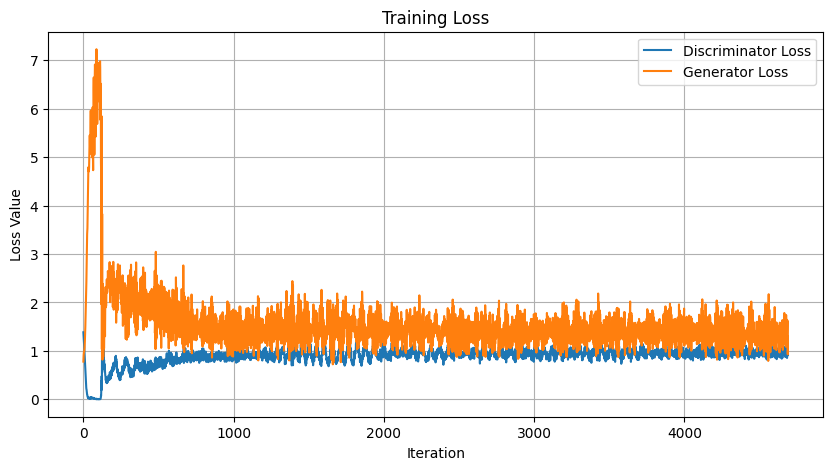

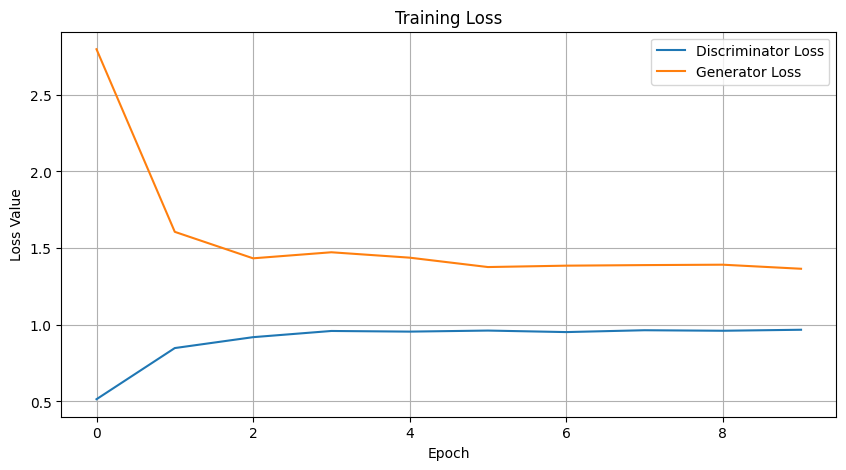

In [188]:
input_dim = 100
batch_size = 128
num_epoch = 10
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
image_dir = './generated_image/'
os.makedirs(image_dir, exist_ok=True)

gan_G = Generator(input_dim).to(device)
gan_D = Discriminator().to(device)

# Define separate Adam optimizers for generator and discriminator
optim_G = torch.optim.Adam(gan_G.parameters(), lr=0.0002)
optim_D = torch.optim.Adam(gan_D.parameters(), lr=0.0002)

# Initialise the list to store the losses for each epoch
iteration_losses_D = []
iteration_losses_G = []
epoch_losses_D = []
epoch_losses_G = []

for epoch in range(num_epoch):
    start_time = time.time()
    total_loss_D, total_loss_G = 0, 0
    
    for i, (x, _) in enumerate(train_loader):
        loss_D, loss_G = training(x)

        iteration_losses_D.append(loss_D.detach().item())
        iteration_losses_G.append(loss_G.detach().item())
        total_loss_D += loss_D.detach().item()
        total_loss_G += loss_G.detach().item()
        
    epoch_losses_D.append(total_loss_D / len(train_loader))
    epoch_losses_G.append(total_loss_G / len(train_loader))
    
    # Save model checkpoints
    if (epoch + 1) % 10 == 0:
        save_checkpoint(epoch + 1, gan_G, gan_D, optim_G, optim_D, checkpoint_dir)

    # losses once per epoch
    print(f'Epoch [{epoch + 1}/{num_epoch}] | Loss_D {iteration_losses_D[-1]:.4f} | Loss_G {iteration_losses_G[-1]:.4f} | Time: {time.time() - start_time:.2f} sec')
    print(f'Epoch [{epoch + 1}/{num_epoch}]  | Loss_D {epoch_losses_D[epoch]:.4f} | Loss_G {epoch_losses_G[epoch]:.4f} | Time: {time.time() - start_time:.2f} sec')
    
    # Task1: visualise the generated image at different epochs
    visualise_generated_images(gan_G, input_dim, epoch, image_dir)
    
# Task2: visualise the loss through a plot
visualise_loss(iteration_losses_D, iteration_losses_G, image_dir, 'Iteration')
visualise_loss(epoch_losses_D, epoch_losses_G, image_dir, 'Epoch')


### Challenge: Applying GANs for Denoising a MNIST image
Using the same GAN network, adjust the code to perform image denoising. You will need to add noise to the initial dataset and retrain the GAN so that it learns the new task of generating the denoised images.
 
You can assess the resulting denoised images through visual inspection and through the computation of MSE and PSNR metrics. MSE and PSNR are always using the original (noise free) image as a reference. Compute the MSE and PSNR of the noisy and the denoised image.

In [189]:
# Challenge - Task3: MSE and PSNR computation for the denoised image and the original image
# Challenge - Task4: MSE and PSNR computation for the noisy image and the original image
def compute_mse(img1, img2):
    return F.mse_loss(img1, img2)
def compute_psnr(mse):
    mse_tensor = torch.tensor(mse)  # Convert the float to a tensor
    return 10 * torch.log10(1 / mse_tensor)

In [190]:
import torch.nn.functional as F
from utils.GAN.generator import Generator
from utils.GAN.discriminator import Discriminator
from utils.GAN.loss import discriminator_loss, generator_loss
from utils.GAN.weights_init import weights_init

# use gpu or cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1 - load MNIST dataset load MNIST dataset
train_dataset = datasets.MNIST(root="./data/", train=True, transform=transforms.ToTensor(), download=False)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
image_size = 28 * 28  # MNIST image size

# Step 2 - instantiate the generator and discriminator
generator = Generator(input_dim=image_size).to(device)
discriminator = Discriminator().to(device)

# Step 3 - define separate Adam optimizers
lr = 0.0001
optim_G = optim.Adam(generator.parameters(), lr=lr)
optim_D = optim.Adam(discriminator.parameters(), lr=lr)

# learning rate scheduler
scheduler_G = torch.optim.lr_scheduler.StepLR(optim_G, step_size=5, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(optim_D, step_size=5, gamma=0.5)

# save Directory
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
image_dir = './denoised_images'
os.makedirs(image_dir, exist_ok=True)

# Initialisation of the network weights
generator.apply(weights_init)
discriminator.apply(weights_init)

# Step 4 - training loop
def training_loop(clean_imgs):
    clean_imgs = clean_imgs.to(device)
    noise = 0.3 * torch.randn(clean_imgs.shape).to(device)  # generate noise
    noisy_imgs = clean_imgs + noise
    noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)

    '''Training step for the Discriminator'''
    generated_imgs = generator(noisy_imgs.view(noisy_imgs.size(0), -1)).view(noisy_imgs.size(0), 1, 28, 28)
    real_output = discriminator(clean_imgs)
    fake_output = discriminator(generated_imgs.detach())
    loss_D = discriminator_loss(real_output, fake_output, device)

    optim_D.zero_grad()
    loss_D.backward()
    optim_D.step()

    '''Training step for the Generator'''
    generated_imgs = generator(noisy_imgs.view(noisy_imgs.size(0), -1)).view(noisy_imgs.size(0), 1, 28, 28)
    fake_output = discriminator(generated_imgs)
    loss_G = generator_loss(fake_output, clean_imgs, generated_imgs )

    optim_G.zero_grad()
    loss_G.backward()
    optim_G.step()

    return loss_D.item(), loss_G.item(), noisy_imgs, clean_imgs

# Step 5 - train the model
num_epochs = 10
for epoch in range(num_epochs):
    total_loss_D, total_loss_G = 0, 0
    for batch_idx, (clean_imgs, _) in enumerate(train_loader):
        # Get noisy_imgs and clean_imgs
        loss_D, loss_G, noisy_imgs, clean_imgs = training_loop(clean_imgs)
        total_loss_D += loss_D
        total_loss_G += loss_G

        # Save only the first batch of images for visualisation
        if batch_idx == 0:
            # Save noisy images
            noisy_img_np = noisy_imgs[0].cpu().numpy()
            plt.imshow(noisy_img_np[0], cmap='gray')  # (channels, height, width) from torch, only 1 channel, because the image is greyscale
            plt.title('Noisy Image')
            plt.savefig(f'{image_dir}/epoch_{epoch + 1}_noisy.png')
            plt.close()

            # Save denoised images
            denoised_img = generator(noisy_imgs.view(noisy_imgs.size(0), -1)).view(noisy_imgs.size(0), 1, 28, 28)
            denoised_img = torch.clamp(denoised_img, 0., 1.)
            denoised_img_np = denoised_img[0].detach().cpu().numpy()
            plt.imshow(denoised_img_np[0], cmap='gray')
            plt.title('Denoised Image')
            plt.savefig(f'{image_dir}/epoch_{epoch + 1}_denoised.png')
            plt.close()

            # Save clean images
            clean_img_np = clean_imgs[0].cpu().numpy()
            plt.imshow(clean_img_np[0], cmap='gray')
            plt.title('Clean Image')
            plt.savefig(f'{image_dir}/epoch_{epoch + 1}_clean.png')
            plt.close()
            
            # Challenge - Compute MSE and PSNR for the noisy and denoised images
            mse_noisy = compute_mse(noisy_imgs, clean_imgs).item()
            mse_denoised = compute_mse(denoised_img, clean_imgs).item()
            psnr_noisy = compute_psnr(mse_noisy)
            psnr_denoised = compute_psnr(mse_denoised)

            # Print MSE and PSNR values
            print(f'Epoch {epoch + 1}/{num_epochs}, MSE and PSNR for noisy and original images: MSE = {mse_noisy}, PSNR = {psnr_noisy}')
            print(f'Epoch {epoch + 1}/{num_epochs}, MSE and PSNR for the denoised and original images: MSE = {mse_denoised}, PSNR = {psnr_denoised}')

    # Learning rate updated
    scheduler_G.step()
    scheduler_D.step()

    # Print the average loss per epoch
    print(f'After Epoch [{epoch + 1}/{num_epochs}], D_loss: {total_loss_D / len(train_loader):.4f}, G_loss: {total_loss_G / len(train_loader):.4f}')

print("Training completed!")

Epoch 1/10, MSE and PSNR for noisy and original images: MSE = 0.04677996039390564, PSNR = 13.299402236938477
Epoch 1/10, MSE and PSNR for the denoised and original images: MSE = 0.46678102016448975, PSNR = 3.308867931365967
After Epoch [1/10], D_loss: 0.0340, G_loss: 24.9474
Epoch 2/10, MSE and PSNR for noisy and original images: MSE = 0.04684538394212723, PSNR = 13.29333209991455
Epoch 2/10, MSE and PSNR for the denoised and original images: MSE = 0.15227177739143372, PSNR = 8.173805236816406
After Epoch [2/10], D_loss: 0.0012, G_loss: 14.0723
Epoch 3/10, MSE and PSNR for noisy and original images: MSE = 0.047194674611091614, PSNR = 13.261070251464844
Epoch 3/10, MSE and PSNR for the denoised and original images: MSE = 0.05517462268471718, PSNR = 12.582606315612793
After Epoch [3/10], D_loss: 0.8742, G_loss: 4.3169
Epoch 4/10, MSE and PSNR for noisy and original images: MSE = 0.04664153605699539, PSNR = 13.312272071838379
Epoch 4/10, MSE and PSNR for the denoised and original images: 